# 1. Characterising companies based on financial metrics during covid19 

## Instructions
In 2020 August, the author started out as a demonstration to adopt the Single-Cell Genomic (SCG) analyses in the business and finance world. The SCG has a high number of features (Up to 56k genes/features) and also frequently known to have low signal with high background. Here, the author demonstrated the correlation of price performance with the common company financial metrics during covid19 period.

## Packages
You'll need to you install the quanp package (https://quanp.readthedocs.io/en/latest/installation.html) that should install all necessary packages/libraries required to execute the codes in this tutorial. Please create and use virtualenv with python version 3.6 to avoid dependency problem.

### Install Packages

In [3]:
import sys
!conda install seaborn scikit-learn statsmodels numba pytables
!conda install -c conda-forge python-igraph leidenalg
!{sys.executable} -m pip install quanp

### Import Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import quanp as qp

from IPython.display import display
from matplotlib import rcParams

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### Download data

In [ ]:
# S&P 500 metadata
df_metadata = qp.datasets.get_wiki_sp500_metadata()

# S&P 500 fundamentals
df_fundamental = qp.datasets.download_tickers_fundamental()

### Loading data

In [6]:
# Optional: The data retried in cell above were saved as csv file You may activated this cell to avoid 
# rerunning the downloading cell above.
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)
print(df_fundamental.columns)

Index(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'beta',
       'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'symbol', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
     

In [7]:
ls_fundamental_target = ['beta','bookValuePerShare','currentRatio', 'dividendYield','epsChangePercentTTM','epsChangeYear',
 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'interestCoverage', 
 'ltDebtToEquity', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM', 
 'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
    'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
    'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
    'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
    'shortIntToFloat', 'totalDebtToCapital', 'totalDebtToEquity',
    'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']

In [8]:
# Loading pandas dataframe as anndata 
adata = qp.AnnData(df_fundamental[ls_fundamental_target])

# log(x+1) transformation for all data
qp.pp.log1p(adata)

# Standardization scaling per feature
qp.pp.scale(adata)

In [9]:
# add a new `.obs` column for all comapnanies called `GICS_Sector`
adata.obs['GICS_Sector'] = df_fundamental['GICS Sector']
adata

AnnData object with n_obs × n_vars = 505 × 37
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p'

### Principal component analysis (PCA)
Reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data.

In [10]:
qp.tl.pca(adata, svd_solver='auto')

We can make a scatter plot using the first 2 principle components' (PCs') coordinates and try to see if these 2 PCs can separate the GICS_Sector well

... storing 'GICS_Sector' as categorical


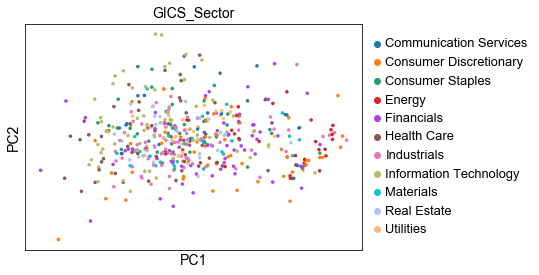

In [11]:
qp.pl.pca(adata, color=['GICS_Sector'], size=50);

For instance, it seems that the Information Technology, Financial, and Energy can be separated from low to high PC1.

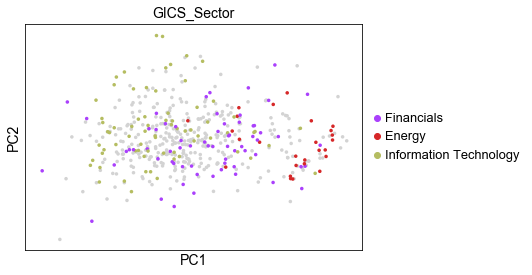

In [12]:
qp.pl.pca(adata, color=['GICS_Sector'], size=50, groups=['Financials', 'Energy', 'Information Technology']);

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function ```qp.tl.leiden()```, ```qp.tl.louvain()```, or ```tSNE qp.tl.tsne()```. In our experience, often, a rough estimate of the number of PCs does fine. The 'elbow' point seems to suggest at least up to PC8 will be useful to characterize the companies. We are going to do further dimensional reduction based on the first 8 PCs later. We will be looking at 

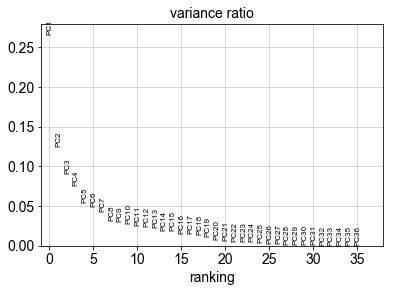

In [13]:
qp.pl.pca_variance_ratio(adata, n_pcs=len(adata.var_names))

In [14]:
# Optional: save the anndata in h5ad for fast loading later
adata.write('sp500_metadata_fundamental.h5ad')
adata

AnnData object with n_obs × n_vars = 505 × 37
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'GICS_Sector_colors'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing the T-distributed Stochastic Neighbor Embedding (tSNE)

Let us further reduce the dimensionality of the signficant PCs identified above wholly in to 2 dimensions using the tSNE tool implemented as ```qp.tl.tsne(adata)```.

In [15]:
qp.tl.tsne(adata, n_pcs=8) # only consider the first 8 pcs

### Computing the neighborhood graph

Before we view the tsne plots with Sector annotations, Let us compute the neighborhood graph of companies using the PCA representation of the data matrix. This will give rise to distances and connectivities in each company. Here, we consider 10 nearest neighbors with 8 PCs derived from the PCA

In [16]:
qp.pp.neighbors(adata, n_neighbors=10, n_pcs=8);

/Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/umap/umap_.py:330: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../anaconda/envs/trading_py36/lib/python3.6/site-packages/umap/umap_.py", line 445:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../anaconda/envs/trading_py36/lib/python3.6/site-packages/umap/umap_.py", line 331:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/Users/leehongka

### Clustering the neighborhood graph

Here, we use Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018) to cluster the neighborhood graph of companies, which we already computed in the previous section.

In [17]:
qp.tl.leiden(adata)

We can now map and view the annotations of leiden clustering, GICS_Sector, or any financial metrics/features on the tsne plots. We see that Leiden Cluster 3 seems to correspond well Financials sector, and it is featured by low currentRatio.

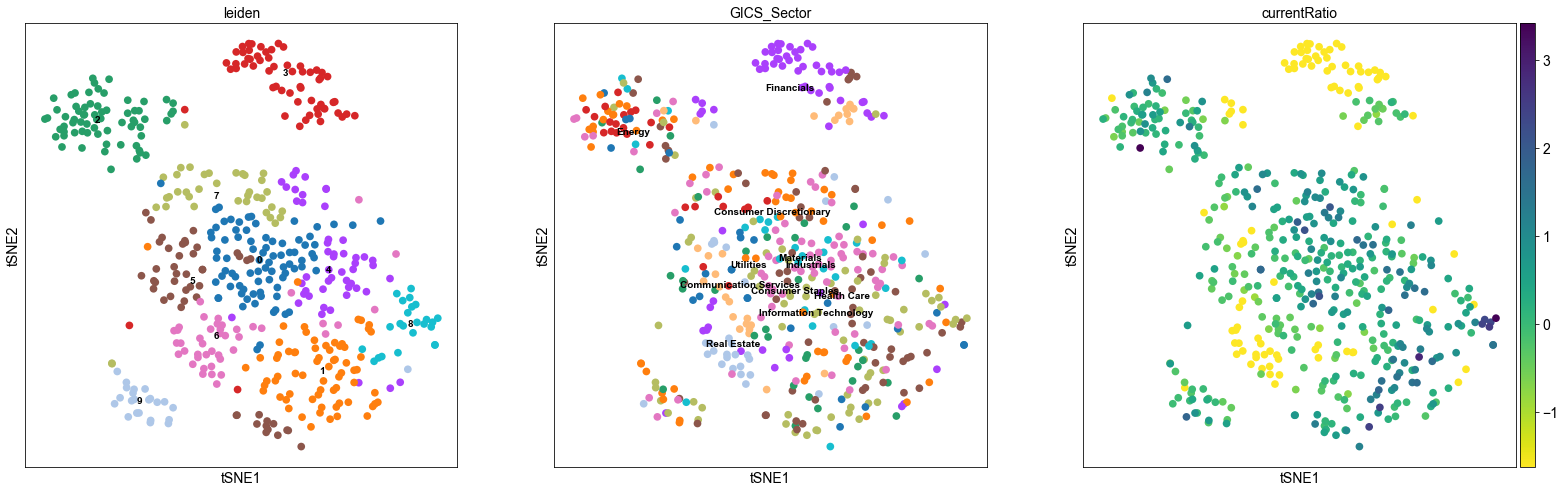

In [18]:
rcParams['figure.figsize'] = 8,8
qp.pl.tsne(adata, color=['leiden', 'GICS_Sector', 'currentRatio'], legend_loc='on data')

### Embedding the neighborhood graph

We can also embed the graph in 2 dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE. Before running the UMAP, we compute the correlations between clusters as initiating positions for the UMAP.

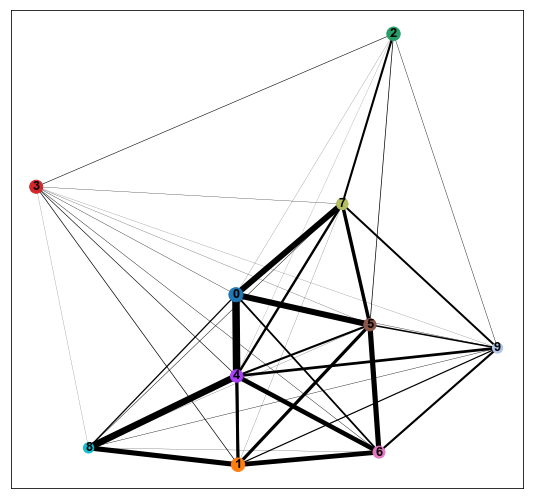

In [19]:
qp.tl.paga(adata)
qp.pl.paga(adata, plot=True)

In [20]:
qp.tl.umap(adata, init_pos='paga')


We can now map and view the annotations of leiden clustering, GICS_Sector, or any financial metrics/features on the umap plots. We see that Leiden Cluster 3 seems to correspond well Financials sector, and it is featured by low currentRatio.

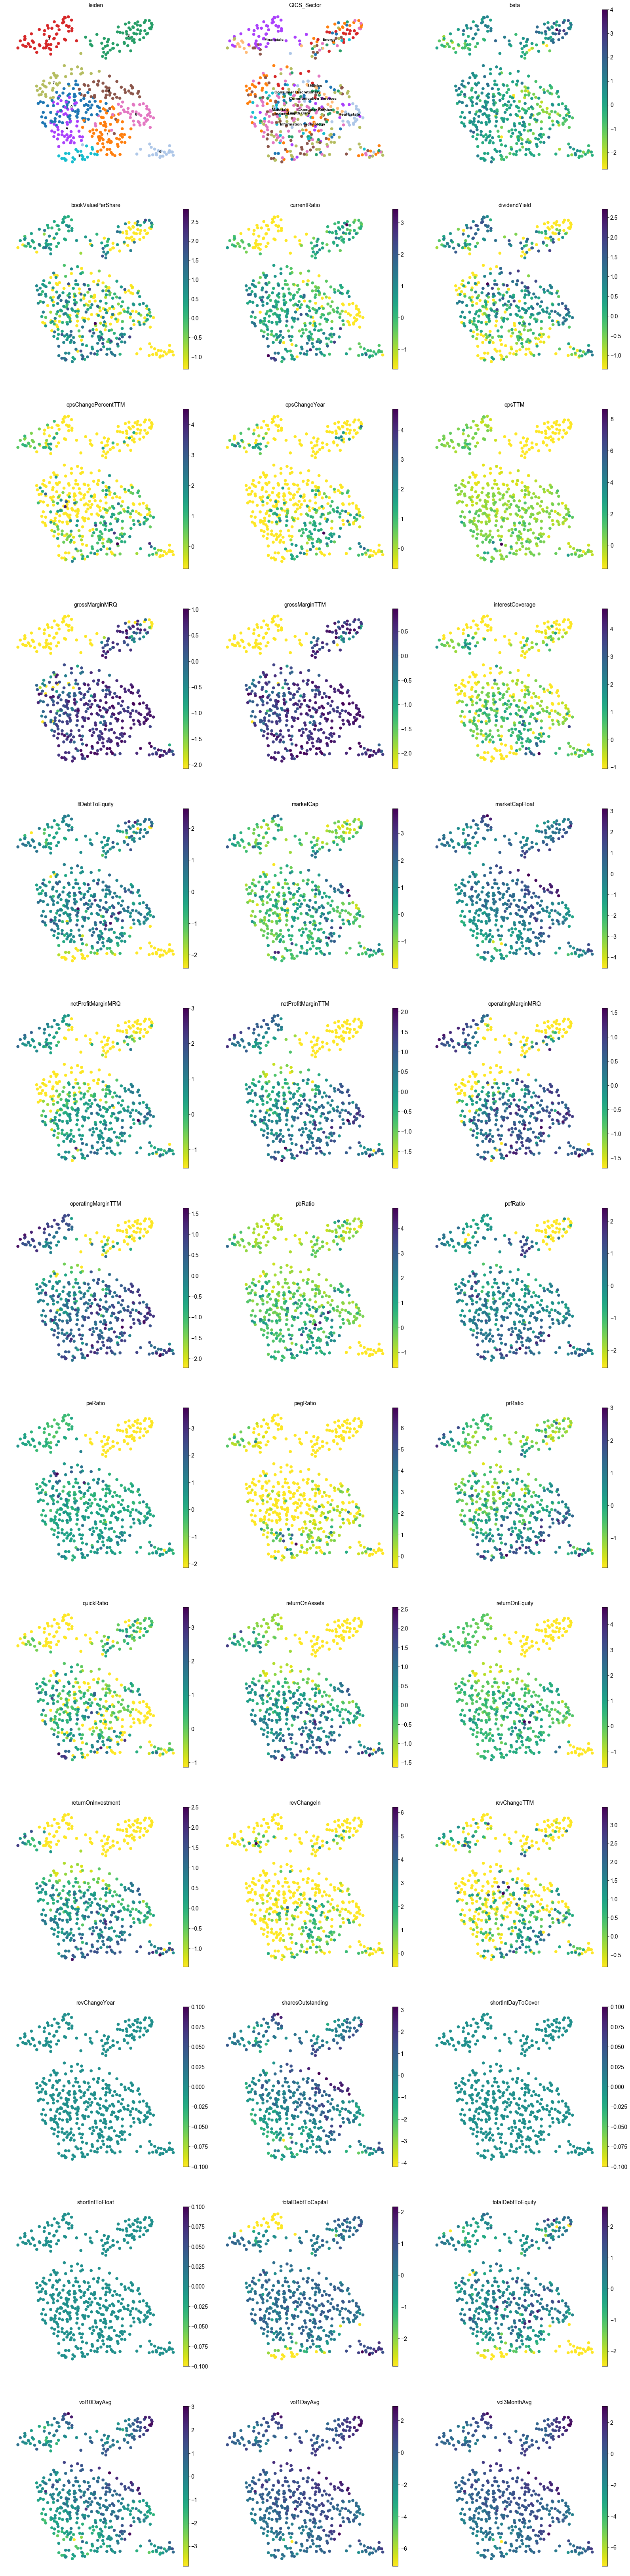

In [21]:
rcParams['figure.figsize'] = 8,8

qp.pl.umap(adata, color=['leiden', 'GICS_Sector'] + list(adata.var_names), legend_loc='on data', frameon=False, ncols=3)

We run `qp.tl.dendrogram` to compute hierachical clustering. Multiple visualizations that can
then include a dendrogram: `qp.pl.matrixplot`, `qp.pl.heatmap`, `qp.pl.dotplot` and `qp.pl.stacked_violin`. 

In [41]:
qp.tl.dendrogram(adata, 'leiden', var_names=adata.var_names)

/Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


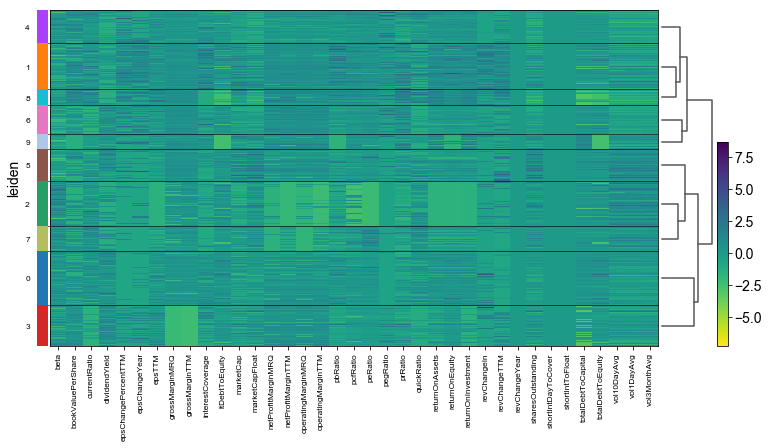

In [33]:
qp.pl.heatmap(adata, adata.var_names, 'leiden', dendrogram=True)

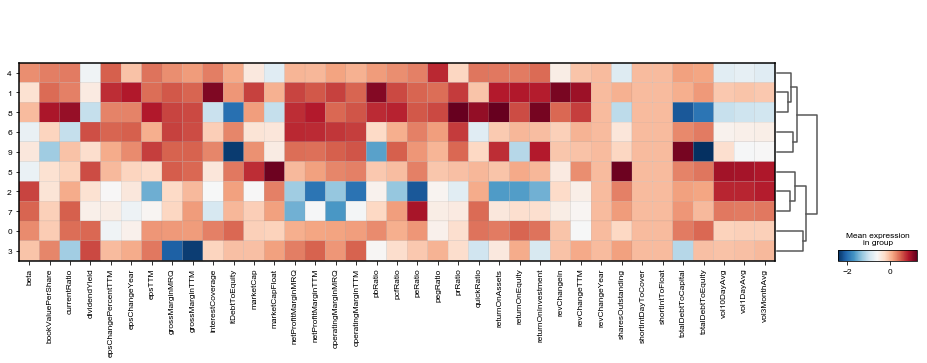

In [37]:
qp.pl.matrixplot(adata, adata.var_names, 'leiden', dendrogram=True, cmap='RdBu_r')

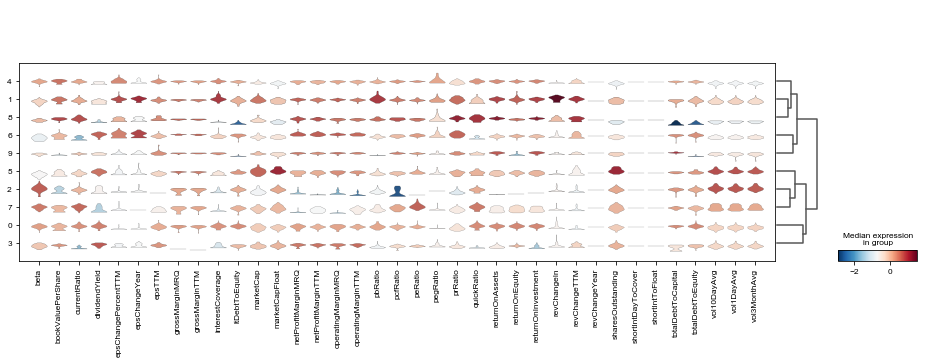

In [44]:
qp.pl.stacked_violin(adata, adata.var_names, 'leiden', dendrogram=True, cmap='RdBu_r')

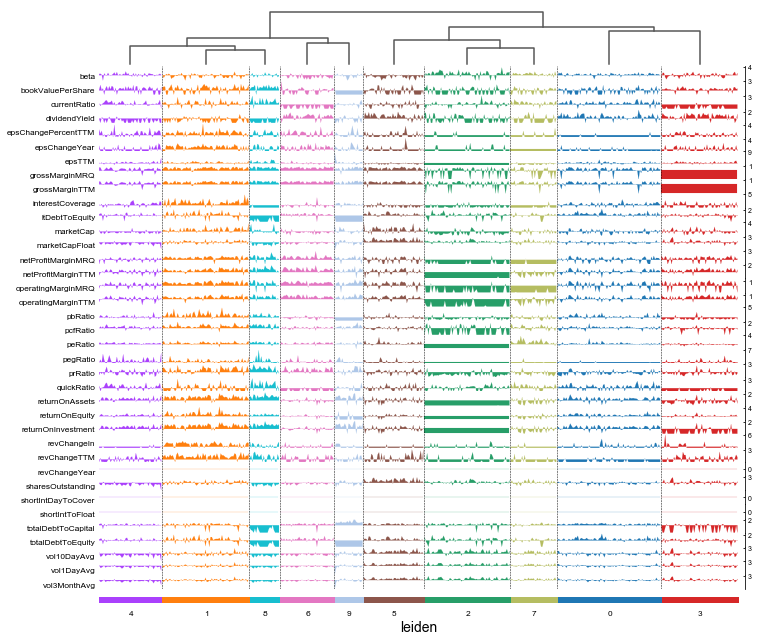

In [46]:
qp.pl.tracksplot(adata, adata.var_names, 'leiden', dendrogram=True)

## Visualizing the important features defining each cluster
Instead of looking at all features of clusters as previously, we can identify features/metrics that are differentially characterizing each cluster. Here, we can see the  Cluster 3 (Mostly consisted of Financials Sector) are correlated significantly higher dividendYield, operatingMarginTTM, netProfitMarginTTM, epsTTM, and netProfitMarginMRQ. 

/Users/leehongkai/anaconda/envs/trading_py36/lib/python3.6/site-packages/quanp/tools/_rank_features_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


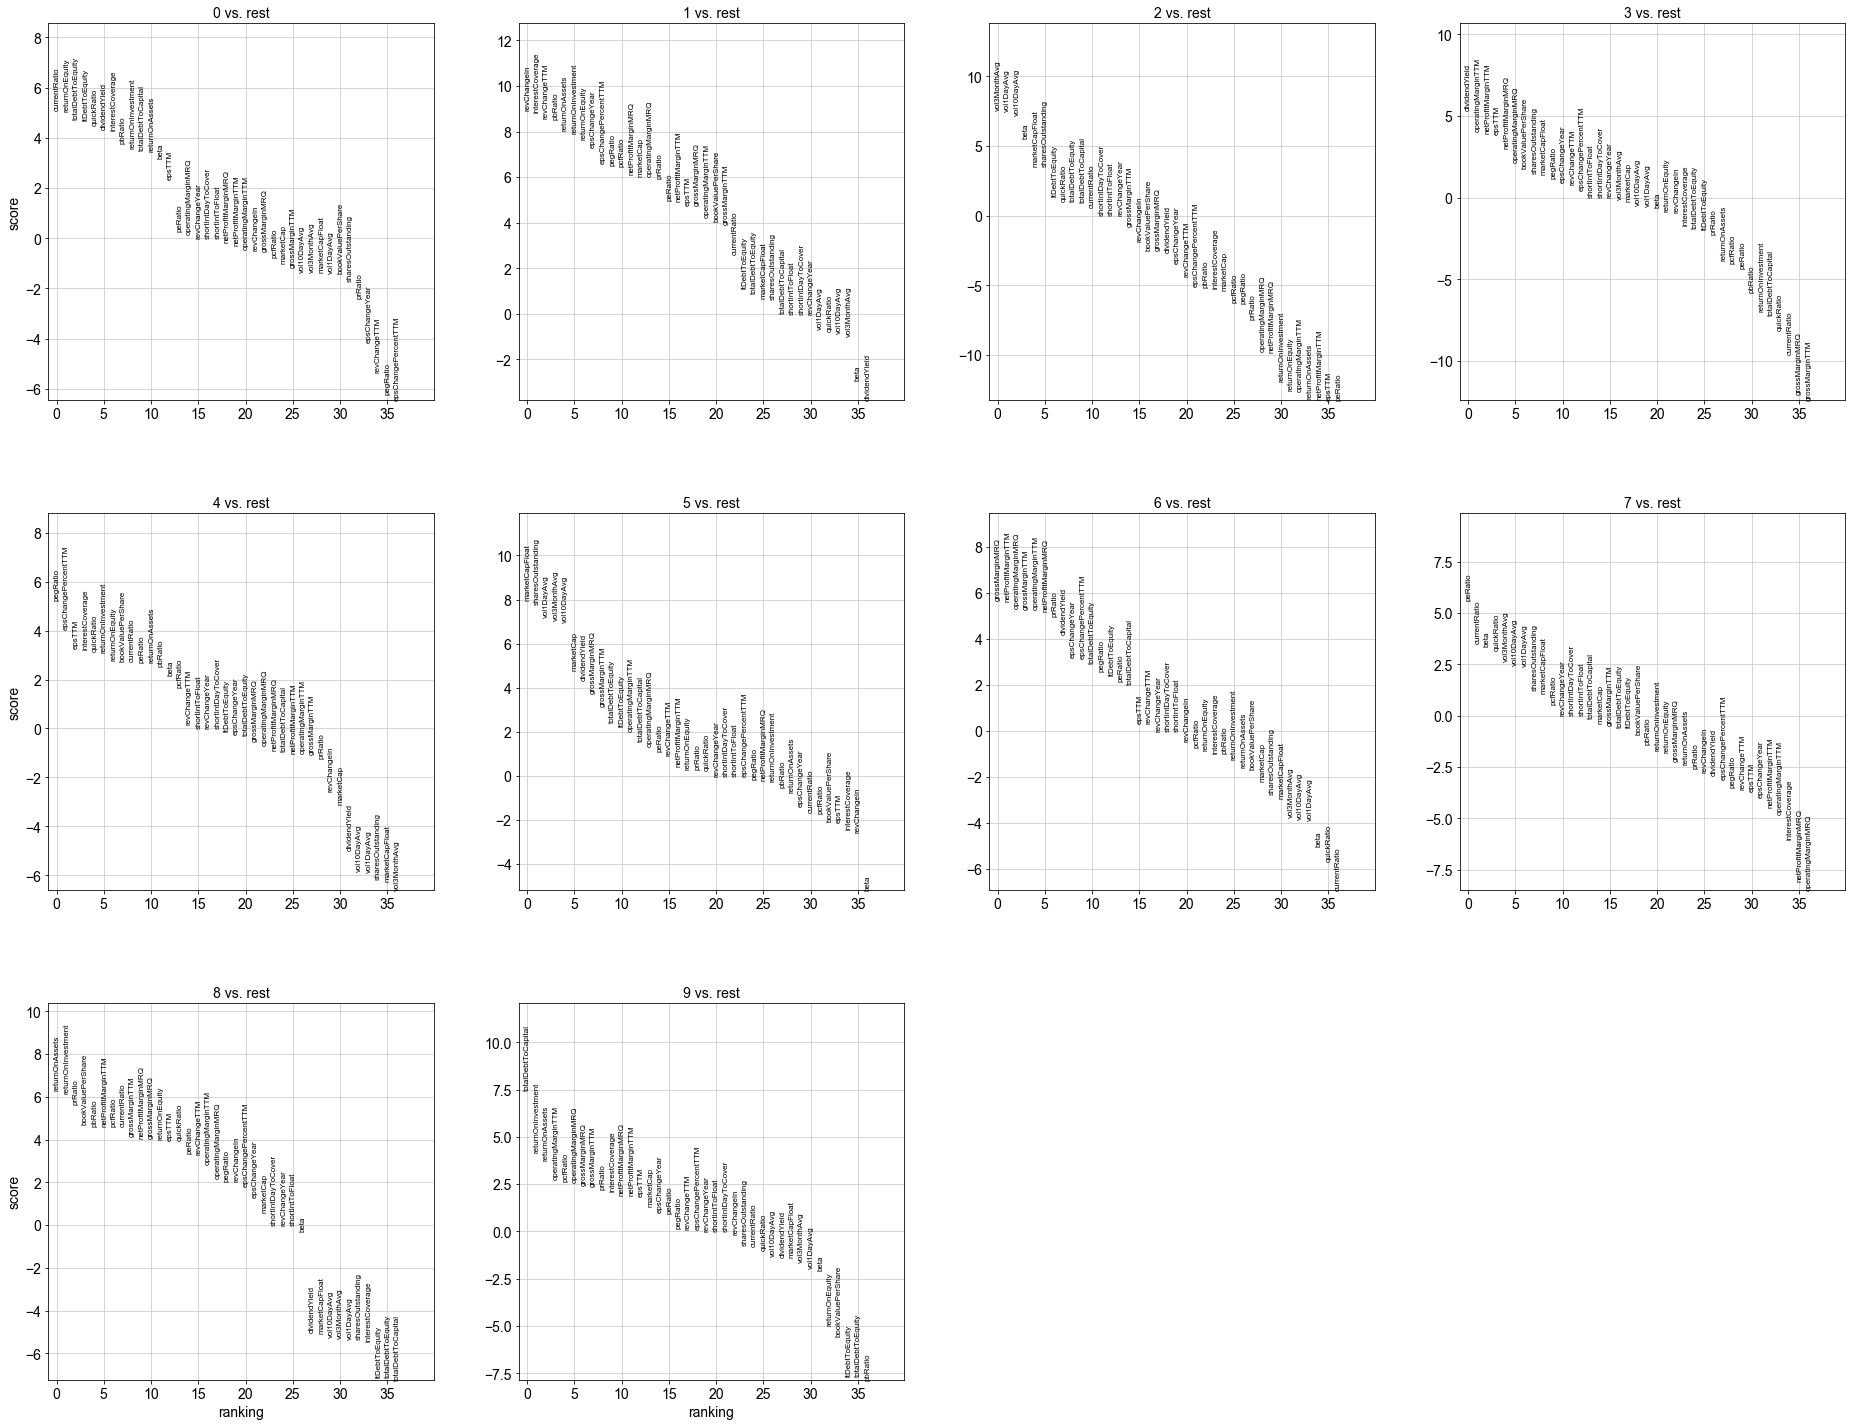

In [47]:
qp.tl.rank_features_groups(adata, 'leiden', method='wilcoxon')
qp.pl.rank_features_groups(adata, n_features=40, sharey=False)

### Visualizing the top 5 positively enriched features using matrixplot

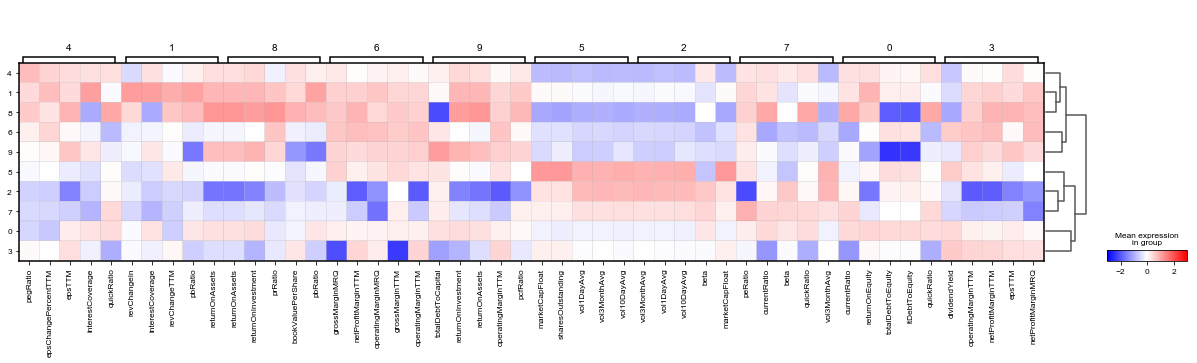

In [49]:
qp.pl.rank_features_groups_matrixplot(adata, n_features=5, use_raw=False, vmin=-3, vmax=3, cmap='bwr')

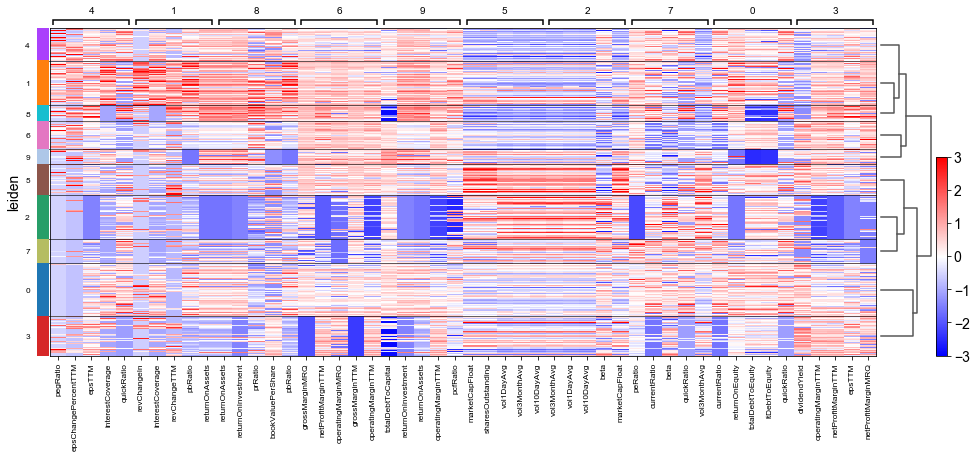

In [54]:
qp.pl.rank_features_groups_heatmap(adata, n_features=5, use_raw=False, vmin=-3, vmax=3, cmap='bwr')

Lastly, we can cross-tabulate the Leiden and GICS_Sector to check correlation between Sector and Leiden definitions.

In [66]:
df_crosstab_sectorVSleiden = pd.merge(pd.DataFrame(adata.obs['leiden']), pd.DataFrame(adata.obs['GICS_Sector']), 
                                      how='inner', left_index=True, right_index=True)
pd.crosstab(df_crosstab_sectorVSleiden['leiden'], df_crosstab_sectorVSleiden['GICS_Sector'])

GICS_Sector  Communication Services  Consumer Discretionary  Consumer Staples  \
leiden                                                                          
0                                 5                       7                 5   
1                                 5                       9                10   
2                                 5                      15                 4   
3                                 0                       0                 0   
4                                 1                       5                 3   
5                                 6                       0                 5   
6                                 1                       0                 3   
7                                 0                      17                 2   
8                                 3                       2                 0   
9                                 0                       6                 1   

GICS_Sector  Energy  Financials  Health Care  Industrials  \
leiden                                                      
0                 2           2            5           28   
1                 0           4           11            8   
2                17           4            6            7   
3                 0          44            5            0   
4                 0           0           12           16   
5                 2           3            6            3   
6                 0           6            1            2   
7                 5           0            6            4   
8                 0           1            8            2   
9                 0           2            2            3   

GICS_Sector  Information Technology  Materials  Real Estate  Utilities  
leiden                                                                  
0                                15         12            1          0  
1                                15          4            2          1  
2                                 4          4            0          2  
3                                 2          0            0         10  
4                                 7          4            2          0  
5                                 9          3            4          7  
6                                 2          0           20          8  
7                                 2          0            1          0  
8                                 8          0            0          0  
9                                 7          1            1          0